# Conditional NF: Ring Radius

**Goal**: Test that conditional normalizing flows correctly learn to generate samples conditioned on a continuous variable.

## Problem Setup

We want to learn the conditional distribution `p(x | r)` of points on a 2D circle:

```
x = (r·cos(θ), r·sin(θ)) + ε,    θ ~ Uniform(0, 2π),    ε ~ N(0, 0.05²)
```

where:
- `x ∈ R²` is the 2D position
- `r ∈ R` is the **radius** (the conditioning variable / context)
- `θ` is a random angle (uniform around the circle)  
- `ε` is small Gaussian noise for numerical stability

**In words**: Given a radius `r`, the target distribution is a noisy ring of that radius centered at the origin.

## Training Data

During training, we sample batches where each point has a random radius `r ~ Uniform(0.5, 3.0)`. The flow sees (x, r) pairs and learns to model `p(x | r)`.

## What This Tests

1. **Context concatenation**: The conditioner MLP receives `[x_masked, r]` as input
2. **Context-dependent outputs**: Different `r` values produce different transformations
3. **Continuous conditioning**: The flow interpolates smoothly across radius values

## Evaluation

- **Visual**: Samples at r=1, 2, 3 should form concentric circles
- **Quantitative**: Mean sample radius ≈ target radius (with std ≈ 0.05 from noise)

In [1]:
# autoreload when changes are made
%load_ext autoreload
%autoreload 2

In [2]:
# add parent directory to path for imports
import sys, os
sys.path.append(os.path.abspath('..'))

In [3]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from nflows.builders import build_realnvp, build_spline_realnvp

In [4]:
# Data generation: points on circle of radius r
def sample_ring(key, radius, n_samples):
    """Sample n points uniformly on circle of given radius."""
    theta = jax.random.uniform(key, (n_samples,), minval=0, maxval=2*jnp.pi)
    x = radius * jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=-1)
    # Add small noise for numerical stability
    x = x + 0.05 * jax.random.normal(jax.random.fold_in(key, 1), x.shape)
    return x

def sample_batch(key, n_samples, r_min=0.5, r_max=3.0):
    """Sample batch with random radii."""
    k1, k2 = jax.random.split(key)
    radii = jax.random.uniform(k1, (n_samples,), minval=r_min, maxval=r_max)
    theta = jax.random.uniform(k2, (n_samples,), minval=0, maxval=2*jnp.pi)
    x = jnp.stack([radii * jnp.cos(theta), radii * jnp.sin(theta)], axis=-1)
    x = x + 0.05 * jax.random.normal(jax.random.fold_in(key, 2), x.shape)
    context = radii[:, None]  # shape (n, 1)
    return x, context

(-3.5, 3.5)

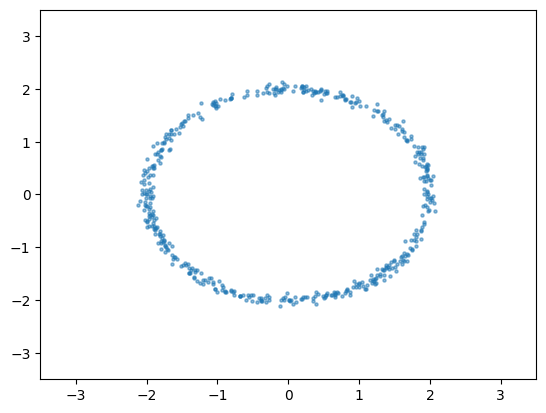

In [5]:
# test data sampling
key = jax.random.PRNGKey(0)
data = sample_ring(key, radius=2.0, n_samples=500)
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=5)

# set auto axis limits
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

In [23]:
# Build conditional flow
key = jax.random.PRNGKey(42)
# flow, params = build_realnvp(
#     key,
#     dim=2,
#     num_layers=16,
#     hidden_sizes=[64, 64],
#     context_dim=1,  # radius
#     loft_tau=10,
# )

# Build spline flow instead
num_layers = 5
hidden_dim = 64
n_hidden_layers = 5
flow, params = build_spline_realnvp(
    key,
    dim=2,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    n_hidden_layers=n_hidden_layers,
    num_bins=8,
    context_dim=1,  # radius
    context_extractor_hidden_dim=2, # small context extractor 2-layer MLP
    use_linear=True,          # add linear layers between coupling layers
    trainable_base=True,        # let the base adapt a bit
    loft_tau=10,
)

print(f"Flow built: dim=2, context_dim=1")

Flow built: dim=2, context_dim=1


In [24]:
# Training
@jax.jit
def loss_fn(params, x, context):
    return -flow.log_prob(params, x, context=context).mean()

@jax.jit 
def train_step(params, opt_state, x, context):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, context)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


lr = 1e-3
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)
r_min=0.5
r_max=3.0

# Training loop
key = jax.random.PRNGKey(0)
losses = []
niter = 10_000
batch_size = 256
for step in range(niter):
    key, subkey = jax.random.split(key)
    x, context = sample_batch(subkey, n_samples=batch_size, r_min=r_min, r_max=r_max)
    params, opt_state, loss = train_step(params, opt_state, x, context)
    losses.append(float(loss))
    if step % 500 == 0:
        print(f"Step {step}: loss = {loss:.4f}")

print(f"Final loss: {losses[-1]:.4f}")

Step 0: loss = 3.6900
Step 500: loss = 1.0528
Step 1000: loss = 0.8563
Step 1500: loss = 0.9343
Step 2000: loss = 0.8537
Step 2500: loss = 0.8251
Step 3000: loss = 0.7288
Step 3500: loss = 0.8264
Step 4000: loss = 0.8851
Step 4500: loss = 0.8577
Step 5000: loss = 0.6359
Step 5500: loss = 0.9156
Step 6000: loss = 0.7506
Step 6500: loss = 0.8264
Step 7000: loss = 0.8295
Step 7500: loss = 0.6952
Step 8000: loss = 0.6888
Step 8500: loss = 0.7629
Step 9000: loss = 0.7730
Step 9500: loss = 0.6662
Final loss: 0.7642


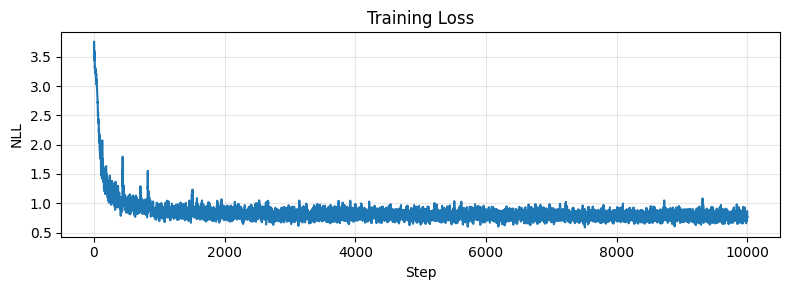

In [25]:
# Plot training loss
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('NLL')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

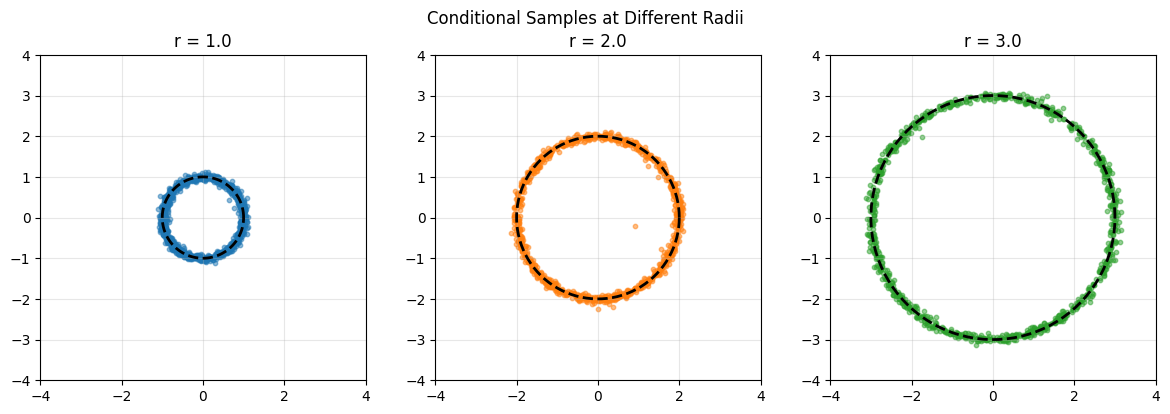

In [26]:
# Sample at different radii and visualize
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
radii_test = [1.0, 2.0, 3.0]
colors = ['tab:blue', 'tab:orange', 'tab:green']
sample_sz = 1_000

key = jax.random.PRNGKey(123)
for ax, r, color in zip(axes, radii_test, colors):
    context = jnp.full((sample_sz, 1), r)
    key, subkey = jax.random.split(key)
    samples = flow.sample(params, subkey, (sample_sz,), context=context)
    
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10, c=color)
    # Draw target circle
    theta = jnp.linspace(0, 2*jnp.pi, 100)
    ax.plot(r * jnp.cos(theta), r * jnp.sin(theta), 'k--', lw=2, label=f'r={r}')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')
    ax.set_title(f'r = {r}')
    ax.grid(True, alpha=0.3)

plt.suptitle('Conditional Samples at Different Radii')
plt.tight_layout()
plt.show()

Radius check (mean ± std of sample radii):
  target r=0.5 -> samples: 0.507 ± 0.056
  target r=1.0 -> samples: 0.995 ± 0.057
  target r=1.5 -> samples: 1.492 ± 0.057
  target r=2.0 -> samples: 1.992 ± 0.056
  target r=2.5 -> samples: 2.498 ± 0.059
  target r=3.0 -> samples: 2.994 ± 0.064
  target r=3.5 -> samples: 3.459 ± 0.069
  target r=4.0 -> samples: 3.892 ± 0.107
  target r=4.5 -> samples: 4.274 ± 0.168
  target r=5.0 -> samples: 4.624 ± 0.243
  target r=5.5 -> samples: 4.897 ± 0.333
  target r=6.0 -> samples: 5.158 ± 0.401
  target r=6.5 -> samples: 5.358 ± 0.460
  target r=7.0 -> samples: 5.556 ± 0.502


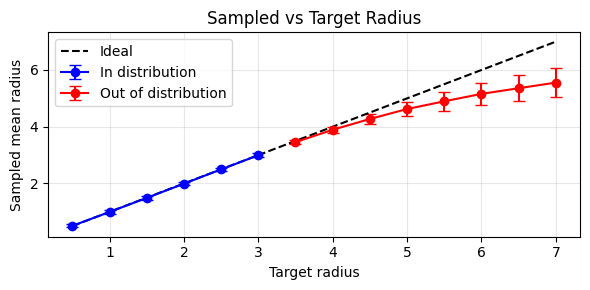

In [27]:
# Purpose: check how well the flow can sample at different radii, 
# including out-of-distribution radii.
import numpy as np
print("Radius check (mean ± std of sample radii):")
key = jax.random.PRNGKey(456)

radius_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5., 5.5, 6., 6.5, 7.]
r_max = 3.0  # Set this according to your OOD threshold

mean_radii = []
std_radii = []

for r in radius_list:
    context = jnp.full((1000, 1), r)
    key, subkey = jax.random.split(key)
    samples = flow.sample(params, subkey, (1000,), context=context)
    sample_radii = jnp.sqrt((samples**2).sum(axis=-1))
    mean_r = float(sample_radii.mean())
    std_r = float(sample_radii.std())
    mean_radii.append(mean_r)
    std_radii.append(std_r)
    print(f"  target r={r:.1f} -> samples: {mean_r:.3f} ± {std_r:.3f}")

plt.figure(figsize=(6,3))
ind_mask = np.array([r <= r_max for r in radius_list])
ood_mask = np.array([r > r_max for r in radius_list])

radius_arr = np.array(radius_list)
mean_arr = np.array(mean_radii)
std_arr = np.array(std_radii)

plt.errorbar(radius_arr[ind_mask], mean_arr[ind_mask], yerr=std_arr[ind_mask], fmt='o-', 
             capsize=4, color='blue', label='In distribution')
plt.errorbar(radius_arr[ood_mask], mean_arr[ood_mask], yerr=std_arr[ood_mask], fmt='o-',
             capsize=4, color='red', label='Out of distribution')
plt.plot(radius_list, radius_list, 'k--', label='Ideal')
plt.xlabel('Target radius')
plt.ylabel('Sampled mean radius')
plt.title('Sampled vs Target Radius')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()